# TASHA - Mode Choice Model

## Using AI to predict the mode choice by persons in household

#### Author: Ahad Beykaei
#### Date: Oct 10, 2017

<em>Model V3</em> <br><br>
One input layer - 49 features (~ , 49) <br>
Four hidden layers - each 256 neurons (49, 256) (256, 256) (256, 5) <br>
One output layer - 5 neurons for 5 types of modes (5, ~) <br>

Scalling variables: Min-Max Scaler <br>
OneHotEncoding categorical data

In [1]:
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.preprocessing import sequence

Using TensorFlow backend.


## Find encoding format of the file 

In [2]:
with open('processedTrips.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
print(result['encoding'])

ascii


## Loading data

In [3]:
df = pd.read_csv("processedTrips.csv", encoding=result['encoding'])

In [4]:
df.head(5)

,HouseholdId,PersonNumber,TripNumber,StartTime,ObservedMode,PurposeOrigin,OriginZone,PurposeDestination,DestinationZone,JointTourID,...,TransitPass,Sex,EmpStat,Occ,FreeParking,AIVTT,ACOST,TransUtil,TransPrice,Distance
0,100001,1,1,700,T,H,591,W,442,0,...,M,M,F,P,N,22.963760,2.567012,143.03660,1.980000,16.777860
1,100001,1,2,1600,T,W,442,H,591,0,...,M,M,F,P,N,19.327180,1.501283,89.97700,1.980000,9.812310
2,100001,2,1,1000,D,H,591,M,482,0,...,N,F,O,O,O,5.467029,0.722114,98.64271,1.980000,4.719703
3,100001,2,2,1100,D,M,482,H,591,0,...,N,F,O,O,O,4.094516,0.549011,75.52932,1.980000,3.588306
4,100007,1,1,1100,D,H,477,O,2255,0,...,N,M,O,O,O,6.147649,1.313678,103.15890,2.669254,8.586128


## Data preprocessing

In [5]:
print("Size of data: " + str(df.shape))

Size of data: (437183, 24)


In [6]:
df.columns

Index(['HouseholdId', 'PersonNumber', 'TripNumber', 'StartTime',
       'ObservedMode', 'PurposeOrigin', 'OriginZone', 'PurposeDestination',
       'DestinationZone', 'JointTourID', 'JointTourRep', 'Cars', 'Age',
       'DriverLicense', 'TransitPass', 'Sex', 'EmpStat', 'Occ', 'FreeParking',
       'AIVTT', 'ACOST', 'TransUtil', 'TransPrice', 'Distance'],
      dtype='object')

In [7]:
df.groupby('ObservedMode').ObservedMode.count()

ObservedMode
C      5182
D    349075
M       354
T     62739
W     19833
Name: ObservedMode, dtype: int64

### Numerical variables description

In [8]:
# Including only numeric columns in a DataFrame description.
# df.describe(include=[np.number]) or exclude=[np.number] or np.object

df[['Cars', 'Age', 'AIVTT', 
    'ACOST', 'TransUtil', 
    'TransPrice', 'Distance']].describe()

,Cars,Age,AIVTT,ACOST,TransUtil,TransPrice,Distance
count,437183.000000,437183.000000,437183.000000,437183.000000,437183.000000,437183.000000,437183.000000
mean,1.760608,48.464384,15.242959,2.218515,166.403107,29.330120,14.171657
std,1.841894,16.412295,15.246949,2.711710,182.197141,160.127512,17.740865
min,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,37.000000,5.127548,0.606866,84.700670,1.980000,3.681851
50%,2.000000,49.000000,10.066300,1.279561,113.884000,1.980000,8.154753
75%,2.000000,60.000000,19.860945,2.783548,169.514450,2.786327,18.014565
max,99.000000,99.000000,189.149900,47.364570,2493.083000,1000.000000,309.572400


### Vectorizing Data

#### <div style="color:#983499">Vectorizing response data (Observed Mode)</div>

In [8]:
from sklearn import preprocessing

# encode labels with value between 0 and n_classes-1.
# 1. INSTANTIATE
le = preprocessing.LabelEncoder()
# use df.apply() to apply le.fit_transform to all columns
y = df[['ObservedMode']]
y = y.apply(le.fit_transform)

# one-hot encoder
# 1. INSTANTIATE
enc = preprocessing.OneHotEncoder()
# 2. FIT
enc.fit(y)
# 3. Transform --> onehotlabels
Y = enc.transform(y).toarray()
Y.shape

(437183, 5)

In [9]:
print(Y)

[[ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.]]


#### <div style="color:#983499">Vectorizing categorical input data</div>

In [10]:
X = df[['PurposeOrigin','PurposeDestination','Cars', 'Age',
       'DriverLicense', 'TransitPass', 'Sex', 'EmpStat', 'Occ', 'FreeParking',
       'AIVTT', 'ACOST', 'TransUtil', 'TransPrice', 'Distance']]
X.head()

,PurposeOrigin,PurposeDestination,Cars,Age,DriverLicense,TransitPass,Sex,EmpStat,Occ,FreeParking,AIVTT,ACOST,TransUtil,TransPrice,Distance
0,H,W,1,42,Y,M,M,F,P,N,22.963760,2.567012,143.03660,1.980000,16.777860
1,W,H,1,42,Y,M,M,F,P,N,19.327180,1.501283,89.97700,1.980000,9.812310
2,H,M,1,40,Y,N,F,O,O,O,5.467029,0.722114,98.64271,1.980000,4.719703
3,M,H,1,40,Y,N,F,O,O,O,4.094516,0.549011,75.52932,1.980000,3.588306
4,H,O,1,62,Y,N,M,O,O,O,6.147649,1.313678,103.15890,2.669254,8.586128


In [11]:
X = df[['PurposeOrigin','PurposeDestination',
       'DriverLicense', 'TransitPass', 'Sex', 'EmpStat', 'Occ', 'FreeParking']]
x_le = X.apply(le.fit_transform)

In [12]:
x_le.head()

,PurposeOrigin,PurposeDestination,DriverLicense,TransitPass,Sex,EmpStat,Occ,FreeParking
0,0,9,2,3,2,1,4,1
1,3,4,2,3,2,1,4,1
2,0,5,2,4,1,4,3,2
3,1,4,2,4,1,4,3,2
4,0,6,2,4,2,4,3,2


In [13]:
# 1. INSTANTIATE
enc = preprocessing.OneHotEncoder()

# 2. FIT
enc.fit(x_le)

# 3. Transform
X_enc = enc.transform(x_le).toarray()
X_enc.shape
# as you can see, you've the same number of rows 891
# but now you've so many more columns due to how we changed all the categorical data into numerical data

(437183, 42)

In [14]:
X_enc

array([[ 1.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 1.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  1.,  0.,  0.]])

### Scaling numerical variables

In [15]:
# scaling numerical input data
# http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
X2 = df[['Cars', 'Age', 'AIVTT', 'ACOST', 'TransUtil', 'TransPrice', 'Distance']]

# from sklearn.preprocessing import scale
# X2 = scale(X2.values)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X2)
X2 = pd.DataFrame(scaled_df)

# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing.data import QuantileTransformer

X2.head()

,0,1,2,3,4,5,6
0,0.010101,0.352273,0.121405,0.054197,0.057373,0.001980,0.054197
1,0.010101,0.352273,0.102179,0.031696,0.036091,0.001980,0.031696
2,0.010101,0.329545,0.028903,0.015246,0.039567,0.001980,0.015246
3,0.010101,0.329545,0.021647,0.011591,0.030296,0.001980,0.011591
4,0.010101,0.579545,0.032501,0.027735,0.041378,0.002669,0.027735


In [16]:
X2.shape

(437183, 7)

In [17]:
# Concatinating the encoded categorical features with the numerical features
X = np.concatenate((X_enc, X2),axis=1)
X.shape

(437183, 49)

### Splitting data into train and test

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=0)

## Network Topology

One input layer - 49 features (~ , 49) <br>
Four hidden layers - each 256 neurons (49, 256) (256, 256) (256, 5) <br>
One output layer - 5 neurons for 5 types of modes (5, ~) 

### Building model

In [19]:
num_classes = 5 # number of transportation modes to be predicted in the model
# {0:'C', 1:'D', 2:'M' , 3:'T' , 4:'W'}

# note: using Dropout between layers to Prevent Neural Networks from Overfitting
# Dropout is a technique where randomly selected neurons are ignored during training. 
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=49))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_fitted = model.fit(x_train, y_train, batch_size=500, epochs=50, validation_data=[x_test, y_test], verbose=2, shuffle=True)

Train on 306028 samples, validate on 131155 samples
Epoch 1/50
10s - loss: 0.3459 - acc: 0.8943 - val_loss: 0.2922 - val_acc: 0.9086
Epoch 2/50
9s - loss: 0.2919 - acc: 0.9087 - val_loss: 0.2672 - val_acc: 0.9152
Epoch 3/50
10s - loss: 0.2720 - acc: 0.9143 - val_loss: 0.2531 - val_acc: 0.9189
Epoch 4/50
10s - loss: 0.2607 - acc: 0.9174 - val_loss: 0.2465 - val_acc: 0.9218
Epoch 5/50
10s - loss: 0.2534 - acc: 0.9196 - val_loss: 0.2448 - val_acc: 0.9225
Epoch 6/50
10s - loss: 0.2492 - acc: 0.9209 - val_loss: 0.2391 - val_acc: 0.9240
Epoch 7/50
10s - loss: 0.2464 - acc: 0.9220 - val_loss: 0.2408 - val_acc: 0.9241
Epoch 8/50
10s - loss: 0.2436 - acc: 0.9228 - val_loss: 0.2388 - val_acc: 0.9236
Epoch 9/50
9s - loss: 0.2418 - acc: 0.9235 - val_loss: 0.2461 - val_acc: 0.9225
Epoch 10/50
12s - loss: 0.2398 - acc: 0.9243 - val_loss: 0.2406 - val_acc: 0.9225
Epoch 11/50
12s - loss: 0.2387 - acc: 0.9245 - val_loss: 0.2353 - val_acc: 0.9249
Epoch 12/50
10s - loss: 0.2376 - acc: 0.9243 - val_loss: 

## Model Summery

In [21]:
model.summary()
print(model_fitted.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               12800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
__________

## Model Validation

### Plot Loss vs epoch

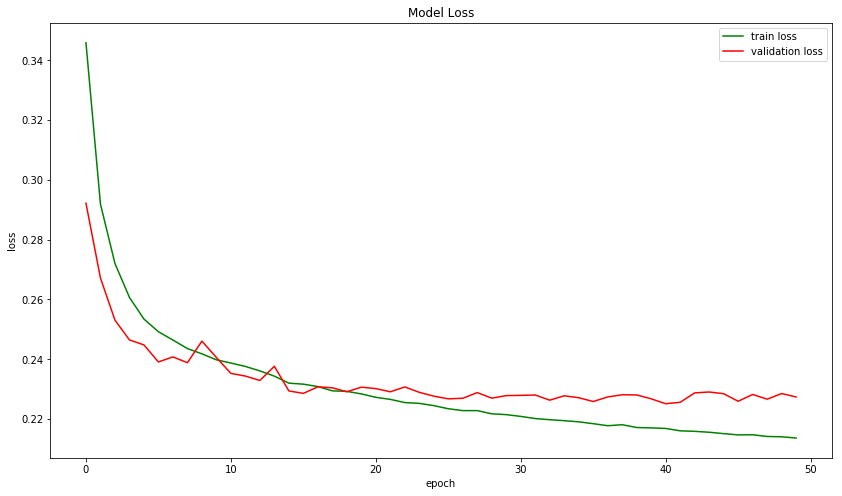

In [22]:
plt.figure(figsize=(14, 8))
plt.plot(model_fitted.history['loss'], color = "green")
plt.plot(model_fitted.history['val_loss'], color = "red")
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

### Plot Accuracy vs. epoch

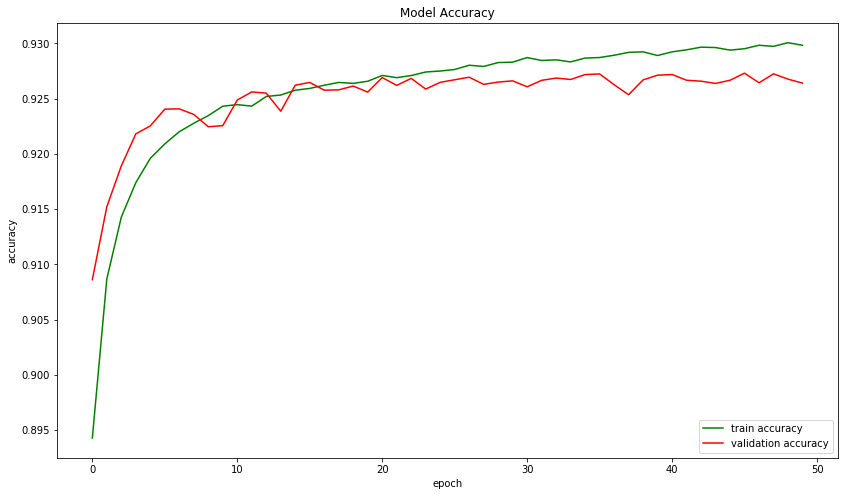

In [23]:
plt.figure(figsize=(14, 8))
plt.plot(model_fitted.history['acc'], color = "green")
plt.plot(model_fitted.history['val_acc'], color = "red")
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

## Predict training data set

In [24]:
predict_train = model.predict(x_train)

In [25]:
Mode_cat = {0:'C', 1:'D', 2:'M' , 3:'T' , 4:'W'}
y_train_df = []
modeChoice_observed = []
modeChoice_predicted = []

for i in range (0, predict_train.shape[0]):
    modeChoice_predicted.append(Mode_cat[np.argmax(predict_train[i])])
    modeChoice_observed.append(Mode_cat[np.argmax(y_train[i])])

y_train_df = pd.DataFrame({'modeChoice_observed':modeChoice_observed,
              'modeChoice_predicted':modeChoice_predicted})    
y_train_df.head()

,modeChoice_observed,modeChoice_predicted
0,D,D
1,T,T
2,D,D
3,D,D
4,D,D


### Accuracy assessment

In [26]:
# summarize performance of the model
scores = model.evaluate(x_train,y_train, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Accuracy: 93.32%


The overall accuracy of the model on the training and the validation dataset is 93.32%

In [28]:
pd.crosstab(y_train_df['modeChoice_observed'], y_train_df['modeChoice_predicted'])

modeChoice_predicted,C,D,T,W
modeChoice_observed,,,,
C,427,1329,1138,753
D,21,240462,3408,611
M,0,225,14,0
T,91,6402,35110,2226
W,48,2436,1743,9584


## Predict testing data set

In [29]:
predict_test = model.predict(x_test)

In [30]:
predict_test

array([[  5.98022863e-02,   4.32873843e-03,   1.30691391e-09,
          8.45473260e-02,   8.51321578e-01],
       [  8.80576670e-04,   9.77457523e-01,   1.77114052e-04,
          2.10170057e-02,   4.67813719e-04],
       [  3.49007011e-03,   9.14594710e-01,   2.79923319e-04,
          1.20789884e-03,   8.04273412e-02],
       ..., 
       [  6.08734845e-04,   2.24773885e-06,   1.86974047e-12,
          9.75772500e-01,   2.36165989e-02],
       [  6.22702800e-02,   8.55738335e-07,   1.51366016e-15,
          1.07476441e-02,   9.26981211e-01],
       [  1.72229096e-01,   2.45127052e-01,   1.23866461e-03,
          4.89205539e-01,   9.21996534e-02]], dtype=float32)

In [31]:
predict_test.shape

(131155, 5)

In [32]:
y_test_df = []
modeChoice_observed = []
modeChoice_predicted = []

for i in range (0, predict_test.shape[0]):
    modeChoice_predicted.append(Mode_cat[np.argmax(predict_test[i])])
    modeChoice_observed.append(Mode_cat[np.argmax(y_test[i])])

y_test_df = pd.DataFrame({'modeChoice_observed':modeChoice_observed,
              'modeChoice_predicted':modeChoice_predicted})    
y_test_df.head()  

,modeChoice_observed,modeChoice_predicted
0,W,W
1,D,D
2,D,D
3,D,D
4,D,D


In [33]:
pd.crosstab(y_test_df['modeChoice_observed'], y_test_df['modeChoice_predicted'])

modeChoice_predicted,C,D,T,W
modeChoice_observed,,,,
C,107,616,495,317
D,12,102500,1730,331
M,0,103,9,3
T,76,2983,14808,1043
W,32,1053,850,4087
